<img align="center" src="../extra/logos/logos.png" width='1200px'>

# Enmascaramiento Sentinel-2 (s2_l2a)

Utilizaremos el notebook `02_Limpieza.ipynb` y `03_Análisis_básico.ipynb` como base para el proceso a desarrollar. Reduciremos el área de estudio para aprovechar la mayor resolución espacial de sentinel-2 con respecto a landsat-8, utilizado en el notebook anteriormente mencionado.

## 0. Cargar librerías y datos

In [1]:
import datacube
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from odc.ui import DcViewer
from datacube.utils import masking
from datacube.utils.rio import configure_s3_access

configure_s3_access(aws_unsigned=False, requester_pays=True)

In [2]:
dc = datacube.Datacube(app='mascara-s2') 

In [3]:
query = {
    "product": "s2_l2a",
    "y": (-33.5, -33.25), 
    "x": (-70.5, -70.25),
    "time": ("2020-01-01", "2020-12-31"),
    "output_crs": "EPSG:32719",
    "resolution": (-10, 10),
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    "group_by": "solar_day"
}

In [4]:
ds = dc.load(**query)
ds

<xarray.Dataset>
Dimensions:      (time: 136, y: 2804, x: 2363)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01T14:42:04.063000 ... 2020-12...
  * y            (y) float64 6.32e+06 6.32e+06 6.32e+06 ... 6.292e+06 6.292e+06
  * x            (x) float64 3.603e+05 3.603e+05 ... 3.839e+05 3.839e+05
    spatial_ref  int32 32719
Data variables: (12/15)
    coastal      (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    rededge1     (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    rededge2     (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    ...           ...
    nir09        (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir16       (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir22       (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    aot          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    wvp          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           epsg:32719
    grid_mapping:  spatial_ref

Podemos observar que obtenemos 136 escenas de 2804 píxeles en el eje y, y 2363 píxeles en el eje x.
Adicionalmente, se obtienen otras bandas que podrían ser de interés, no disponibles en la serie landsat, tales como `rededge1`, `rededge2`, `rededge3`, `nir`, y `nir09`.

Por otra parte, las últimas 3 bandas consisten en: 
* scl: Scene Classification
* aot: Aerosol Optical Thickness
* wvp: Water Vapour

De estas utilizaremos `scl` para enmascarar las imágenes.

***

## 1. Enmascarar valores no válidos y/o no requeridos

En el notebook `02_Limpieza.ipynb` mencionamos 2 maneras obtener las máscaras que eran equivalentes, llamadas `AND` y `OR`. 

Realizaremos un repaso:

### 1.1 Operador lógico `AND`

Bajo la utilización del operador `AND` marcabamos los píxeles que sí queremos mantener y enmascararemos el resto. 
Mostraremos los resultados obtenidos mediante landsat-8 para ejemplificar la diferencia con respecto a sentinel-2.

#### Landsat-8

In [5]:
query = {
    "product": "landsat8_c2l2_sr",
    "y": (-33.5, -33.25), 
    "x": (-70.5, -70.25),
    "time": ("2020-01-01", "2020-12-31"),
    "output_crs": "EPSG:32719",
    "resolution": (-30, 30),
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    "group_by": "solar_day"
}
ds_landsat = dc.load(**query)

Aquí abajo se presenta la query y el código para sacar de la escena las nubes `"cloud"`, las nubes "cirrus" `"cirrus"`, la sombra que producen las nubes `"cloud_shadow"`, y los píxeles inválidos `"nodata"`:

In [6]:
good_pixel_flags = {
    "cloud": "not_high_confidence",
    "cirrus": "not_high_confidence",
    "cloud_shadow": "not_high_confidence",
    "nodata": False
}

In [7]:
bandas_reflectancia = ["coastal", "blue", "green", "red", "nir08", "swir16", "swir22"]
quality_band = 'qa_pixel'
cloud_free_mask0 = masking.make_mask(ds_landsat[quality_band], **good_pixel_flags)
dsf_landsat = ds_landsat[bandas_reflectancia].where(cloud_free_mask0)

Esto funciona correctamente gracias a la forma en que se almacenan las `flags`
Cada fila presenta un nombre y asociado a ese nombre existen `values` que podemos llamar mediante un número o un texto, por ejemplo:
* en `good_pixel_flags` pedimos que `cloud` sea `not_high_confidence`, es decir, un pixel adecuado no pude tener una alta confiabilidad de ser nube.
* en la descripción a continuación se aprecia qe dentro de la fila `cloud`, en la columna `values`, `not_high_confidence` es un valor factible.

In [8]:
datacube.utils.masking.describe_variable_flags(ds_landsat)

,bits,values,description
snow,5,"{'0': 'not_high_confidence', '1': 'high_confid...",NaN
clear,6,"{'0': 'not_clear', '1': 'clear'}",NaN
cloud,3,"{'0': 'not_high_confidence', '1': 'high_confid...",NaN
water,7,"{'0': 'land_or_cloud', '1': 'water'}",NaN
cirrus,2,"{'0': 'not_high_confidence', '1': 'high_confid...",NaN
nodata,0,"{'0': False, '1': True}",NaN
qa_pixel,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","{'1': 'Fill', '2': 'Dilated Cloud', '4': 'Cirr...",Level 2 pixel quality
cloud_shadow,4,"{'0': 'not_high_confidence', '1': 'high_confid...",NaN
dilated_cloud,1,"{'0': 'not_dilated', '1': 'dilated'}",NaN
cloud_confidence,"[8, 9]","{'0': 'none', '1': 'low', '2': 'medium', '3': ...",NaN


#### Sentinel-2

En el caso de sentinel 2, la descripción de los flags no es igual que en landsat-8:

In [9]:
datacube.utils.masking.describe_variable_flags(ds)

,bits,values,description
qa,"[0, 1, 2, 3, 4, 5, 6, 7]","{'0': 'no data', '1': 'saturated or defective'...",Sen2Cor Scene Classification


Como podemos observar solo tenemos la fila `qa`, que es equivalente a `qa_pixel` en landsat-8.

Podemos explorar los valores que posee la fila `qa`:

In [10]:
datacube.utils.masking.describe_variable_flags(ds)["values"]["qa"]

{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

Utilizando los códigos en equivalencia al ejemplo de landsat debiesemos hacer como sigue:

In [11]:
good_pixel_flags = {
    "cloud": "not_high_confidence",
    "cirrus": "not_high_confidence",
    "cloud_shadow": "not_high_confidence",
    "nodata": False
}

In [12]:
bandas_reflectancia = ["coastal", "blue", "green", "red", "nir08", "swir16", "swir22"]
quality_band = 'qa'
cloud_free_mask1 = masking.make_mask(ds[quality_band], **good_pixel_flags)
dsf = ds[bandas_reflectancia].where(cloud_free_mask1)

KeyError: 'qa'

El error anterior indica que `qa` no es compatible con los nombres que tiene `good_pixel_flags`. Si utilizamos los valores que se observan en `qa`:

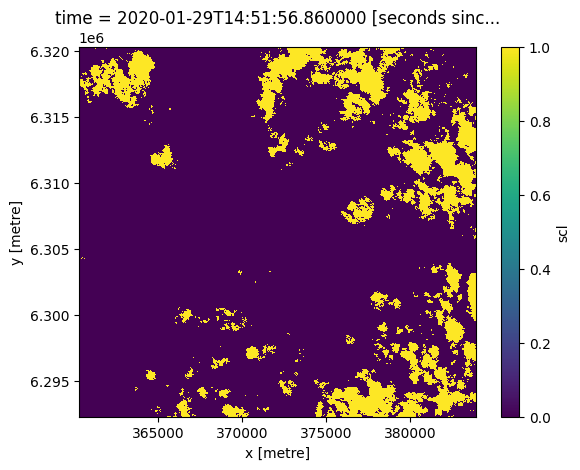

In [13]:
masking.make_mask(ds.scl, **{'qa': 'cloud high probability'}).isel(time = 11).plot()

Excelente, hemos obtenido la máscara asociada a la alta probabilidad de nubes.
Sigamos con cirrus:

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


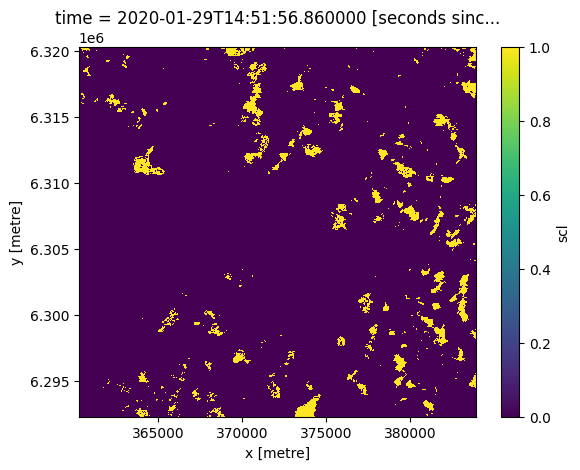

In [14]:
masking.make_mask(ds.scl, **{'qa': 'cloud shadows'}).isel(time = 11).plot()

Bien, y ¿si intentamos unirlos?

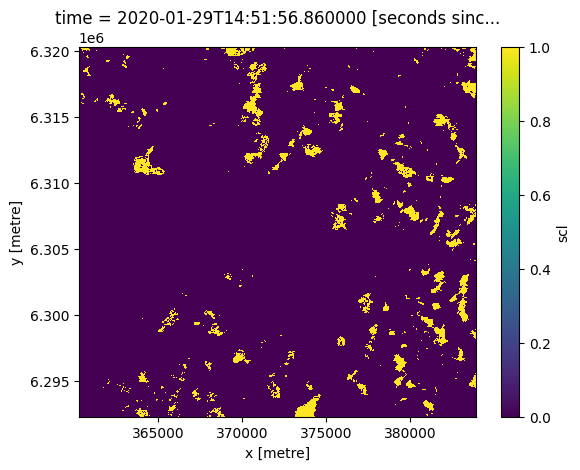

In [15]:
masking.make_mask(ds.scl, **{'qa': 'cloud high probability', 'qa': 'cloud shadows'}).isel(time = 11).plot()

Lamentablemente el resultado es igual al de solamente `cloud shadows`. La celda anterior sobreescribe el valor de `qa` debido a que lo llamamos 2 veces continuas. Por ende, no recomendamos utilizar este operador lógico.

### 1.2 Operador lógico `OR`

Afortunadamente es más sencillo acceder a enmascarar bajo este operador, simplemente hay que repetir las variables requeridas.

Recordemos que, bajo este operador, debemos marcar los píxeles que no queremos para sacarlos.

Continuemos con el ejercicio anterior, obtengamos la máscara para `cloud high probability` y `cloud shadows`:

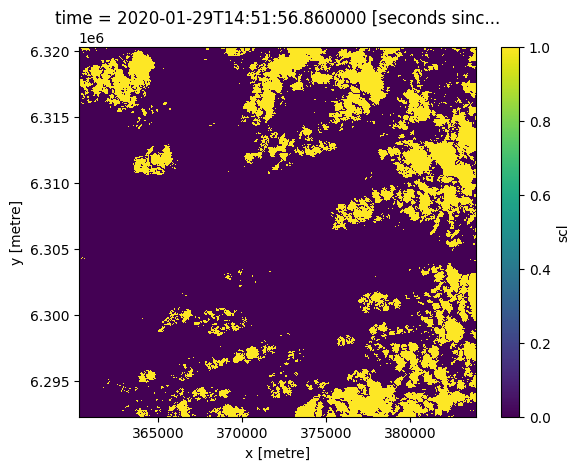

In [16]:
(masking.make_mask(ds.scl, qa="cloud high probability") | masking.make_mask(ds.scl, qa="cloud shadows")).isel(time = 11).plot()

Ahora sí obtuvimos el resultado que estuvimos buscando.

Ahora excluyamos los valores que no requerimos:

In [17]:
datacube.utils.masking.describe_variable_flags(ds)["values"]["qa"]

{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

In [18]:
cloud_free_mask2 = (
    masking.make_mask(ds.scl, qa="no data") | 
    masking.make_mask(ds.scl, qa="cloud shadows") | 
    masking.make_mask(ds.scl, qa="cloud medium probability") |
    masking.make_mask(ds.scl, qa="cloud high probability") |
    masking.make_mask(ds.scl, qa="thin cirrus")
)


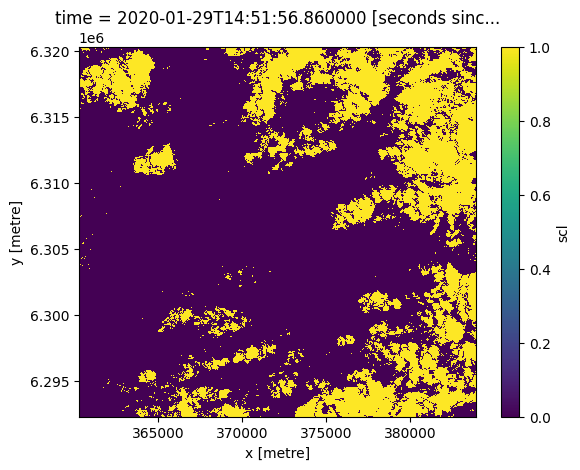

In [19]:
cloud_free_mask2.isel(time = 11).plot()

In [20]:
dsf = xr.where(cloud_free_mask2, np.nan, ds[bandas_reflectancia])

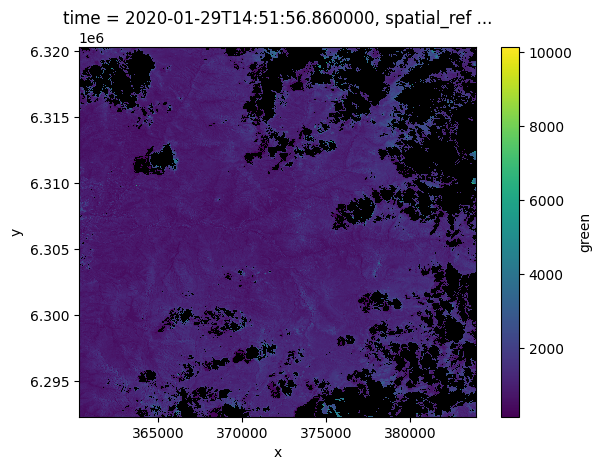

In [21]:
fig, ax = plt.subplots(1, 1)
dsf.green.isel(time=11).plot()
ax.set_facecolor("black")

Se aprecia el resultado esperado, excluyendo las nubes y sus sombras.

***